# Denoising experiments

## Import libraries

In [67]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn

## Step 1: Data Analysis

In [68]:
df = pd.read_csv(r"C:\Users\Admin\Downloads\OpenBCI-RAW-2024-02-02_15-01-41.txt", comment='%')
df = df.rename(columns=lambda x: x.strip())
df = df[5:]
df.head()

,Sample Index,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8,...,Other.3,Other.4,Other.5,Other.6,Analog Channel 0,Analog Channel 1,Analog Channel 2,Timestamp,Other.7,Timestamp (Formatted)
5,6.0,60097.470593,63373.498723,-30929.204038,-2449.259454,17784.076069,9420.790901,28911.824991,4166.231056,33888.016211,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.702
6,8.0,60103.214991,63383.400546,-30918.229332,-2395.458805,17784.970139,9449.512893,28909.790982,4172.154268,33891.391324,...,15.5,48.0,3.0,104.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.710
7,10.0,60103.013826,63379.265473,-30916.977634,-2425.164273,17783.964310,9441.689782,28909.813334,4172.310730,33902.075458,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.718
8,12.0,60108.221782,63382.618234,-30913.222541,-2382.695959,17795.654273,9439.745181,28930.667511,4179.083309,33905.584682,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.726
9,14.0,60104.354930,63375.599787,-30920.822134,-2410.725046,17791.988586,9438.806407,28925.034872,4171.573123,33920.739164,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.706883e+09,0.0,2024-02-02 15:01:41.735


In [69]:
df.columns

Index(['Sample Index', 'EXG Channel 0', 'EXG Channel 1', 'EXG Channel 2',
       'EXG Channel 3', 'EXG Channel 4', 'EXG Channel 5', 'EXG Channel 6',
       'EXG Channel 7', 'EXG Channel 8', 'EXG Channel 9', 'EXG Channel 10',
       'EXG Channel 11', 'EXG Channel 12', 'EXG Channel 13', 'EXG Channel 14',
       'EXG Channel 15', 'Accel Channel 0', 'Accel Channel 1',
       'Accel Channel 2', 'Other', 'Other.1', 'Other.2', 'Other.3', 'Other.4',
       'Other.5', 'Other.6', 'Analog Channel 0', 'Analog Channel 1',
       'Analog Channel 2', 'Timestamp', 'Other.7', 'Timestamp (Formatted)'],
      dtype='object')

In [70]:
def plot_eeg(data, figsize=(20, 15), title=None):
    if isinstance(data, torch.Tensor):
        data = data.detach().numpy()

    num_plots = data.shape[1]

    fig, ax = plt.subplots(num_plots, 1, figsize=figsize)
    x = range(len(data))

    if data.ndim == 1:
        data = data[:, None]

    if num_plots == 1:
        ax = [ax]
        # data = data.reshape(1, -1)

    for i in range(num_plots):
        ax[i].plot(x, data[:, i], linewidth=0.5)
        ax[i].set_xlabel("Iter")
        ax[i].set_ylabel("Voltage ($\mu V$)")
        if title:
            ax[i].set_title(title)
        else:
            ax[i].set_title(df.columns[start_idx+i])

    plt.tight_layout()
    plt.show()

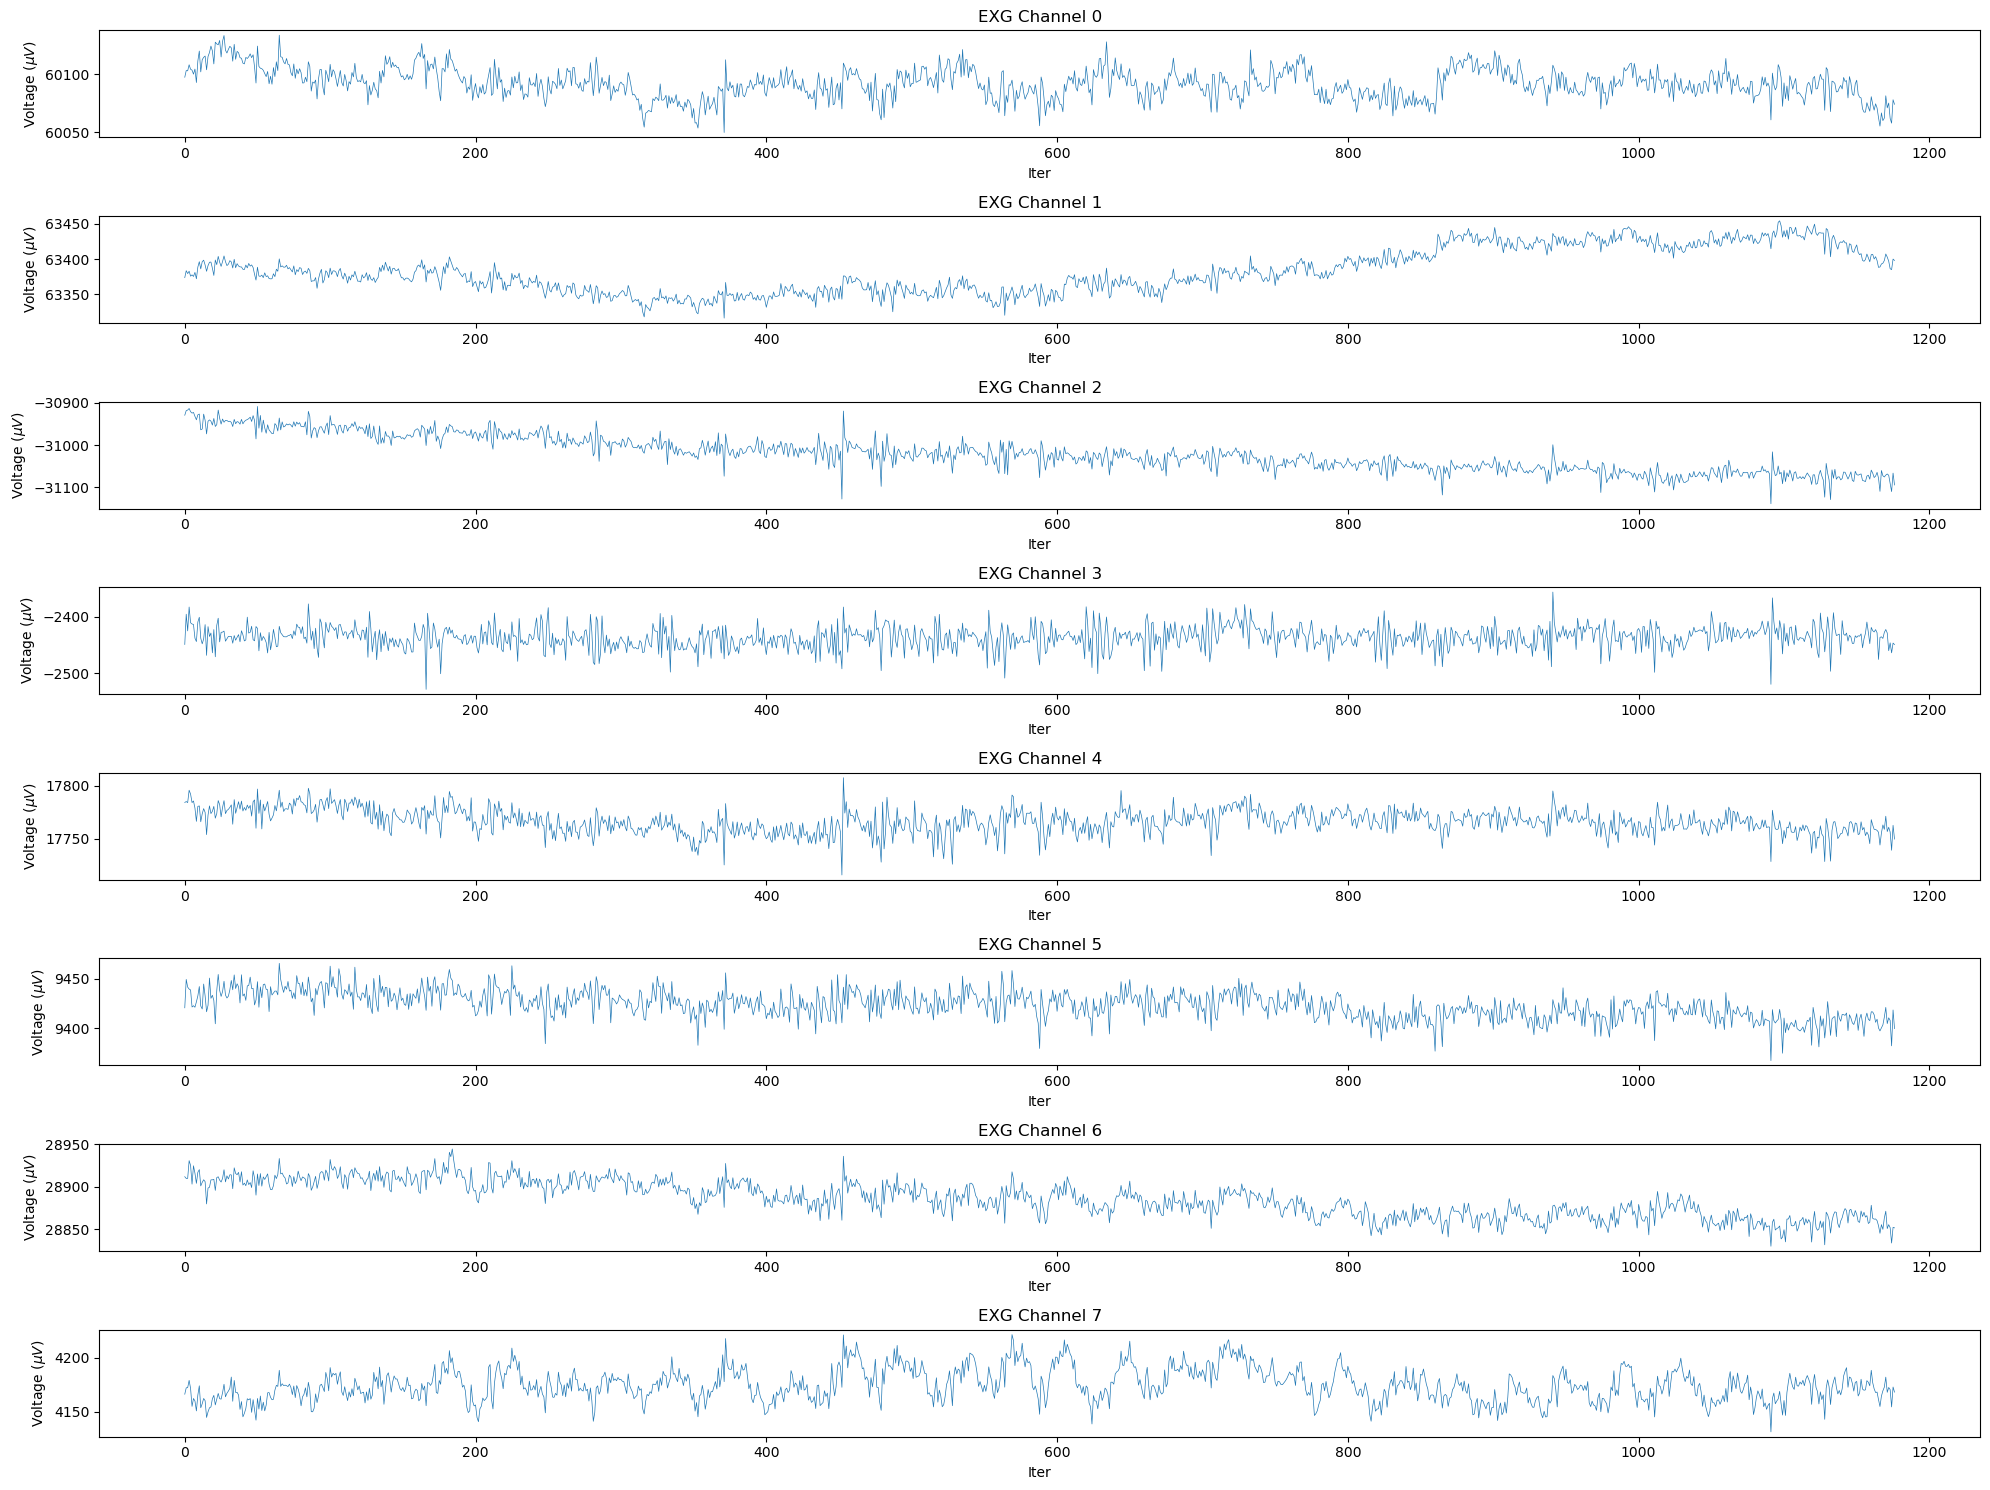

In [71]:
start_idx = 1
end_idx = start_idx + 8
raw_data = df.iloc[:, start_idx:end_idx].to_numpy()
plot_eeg(raw_data)

## 1. 1D Convolutions

In [72]:
data_conv_df = df.iloc[:, 1]
data_conv_df.head()

5    60097.470593
6    60103.214991
7    60103.013826
8    60108.221782
9    60104.354930
Name: EXG Channel 0, dtype: float64

In [73]:
data_conv = torch.tensor(data_conv_df.to_numpy(), dtype=torch.float32).view(1, 1, -1)

In [74]:
class ConvolutionNoiseReductor(nn.Module):
    def __init__(self, kernel_size, stride=None, padding=0):
        super(ConvolutionNoiseReductor, self).__init__()
        self.conv = nn.Conv1d(1, 1, kernel_size=kernel_size, stride=stride, padding=padding)

    def forward(self, x):
        x = self.conv(x)
        return x

In [75]:
model = ConvolutionNoiseReductor(kernel_size=256, stride=16)

result = model(data_conv)

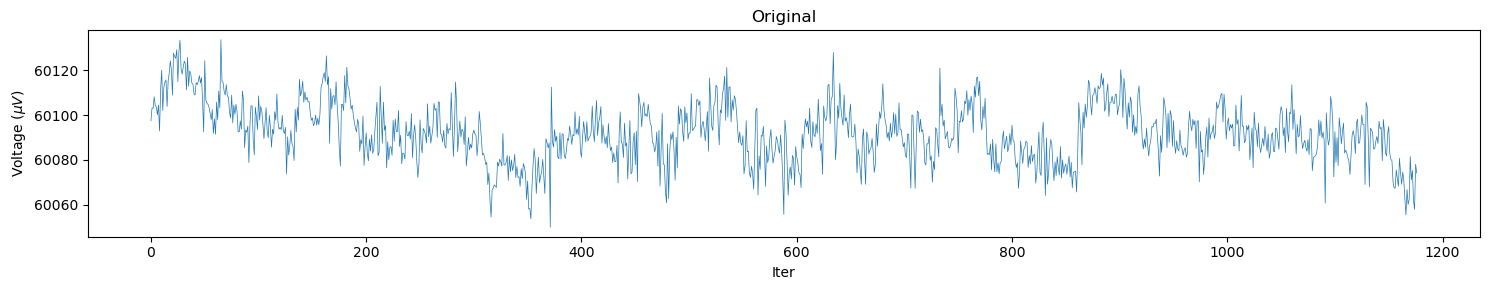

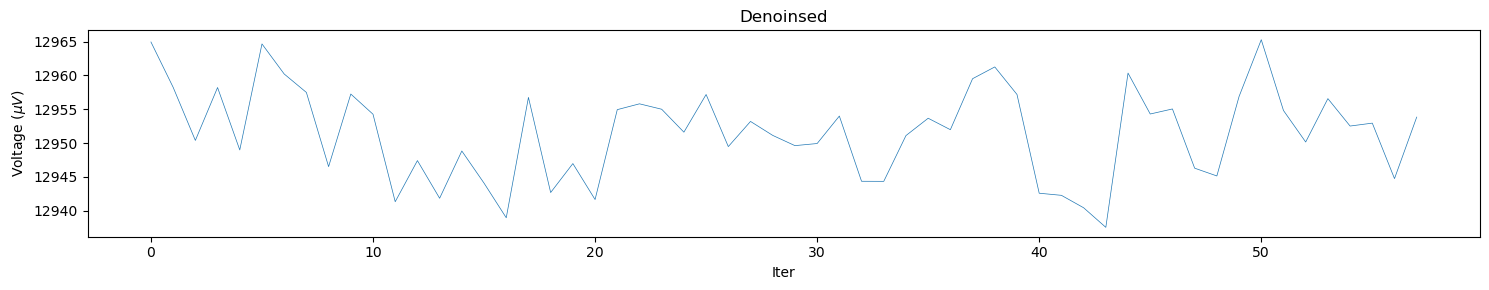

In [76]:
plot_eeg(df["EXG Channel 0"].to_numpy()[..., np.newaxis], figsize=(15, 3), title="Original")
plot_eeg(result[0, :, :].T, figsize=(15, 3), title="Denoinsed")

**Convolutions ❌** \\
One major flaw of using convolutions for EEG signal denoising is that the values have a very large shift after applying the convolution.

## 2. ICA

In [77]:
!pip install -q mne

In [78]:
import mne
from mne.preprocessing import ICA

In [79]:
data_ica_df = df.iloc[:, 1:10]
data_ica_df.head()

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8
5,60097.470593,63373.498723,-30929.204038,-2449.259454,17784.076069,9420.790901,28911.824991,4166.231056,33888.016211
6,60103.214991,63383.400546,-30918.229332,-2395.458805,17784.970139,9449.512893,28909.790982,4172.154268,33891.391324
7,60103.013826,63379.265473,-30916.977634,-2425.164273,17783.964310,9441.689782,28909.813334,4172.310730,33902.075458
8,60108.221782,63382.618234,-30913.222541,-2382.695959,17795.654273,9439.745181,28930.667511,4179.083309,33905.584682
9,60104.354930,63375.599787,-30920.822134,-2410.725046,17791.988586,9438.806407,28925.034872,4171.573123,33920.739164


In [80]:
sfreq = 100
info = mne.create_info(ch_names=data_ica_df.columns.tolist(), sfreq=sfreq, ch_types='eeg')

raw = mne.io.RawArray(data_ica_df.T.values, info)

ica = ICA(n_components=None, random_state=42, max_iter=800)
raw.filter(l_freq=1.0, h_freq=None)
ica.fit(raw)

Creating RawArray with float64 data, n_channels=9, n_times=1177
    Range : 0 ... 1176 =      0.000 ...    11.760 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 331 samples (3.310 s)

Fitting ICA to data using 9 channels (please be patient, this may take a while)
Selecting by non-zero PCA components: 9 components
Fitting ICA took 0.1s.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:    0.0s finished


Method,fastica
Fit parameters,algorithm=parallelfun=logcoshfun_args=Nonemax_iter=800
Fit,16 iterations on raw data (1177 samples)
ICA components,9
Available PCA components,9
Channel types,eeg
ICA components marked for exclusion,—


In [81]:
ica.apply(raw)
denoised_df = pd.DataFrame(raw.get_data().T, columns=data_ica_df.columns.tolist())
denoised_df.head()

Applying ICA to Raw instance
    Transforming to ICA space (9 components)
    Zeroing out 0 ICA components
    Projecting back using 9 PCA components


,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8
0,-2.898109e-12,1.816205e-11,6.239225e-12,-8.453174e-13,3.666173e-12,2.067781e-12,4.675225e-12,1.026740e-12,4.955716e-12
1,5.508207e+00,9.667687e+00,1.136405e+01,5.345998e+01,9.853559e-01,2.836967e+01,-1.977089e+00,5.962396e+00,1.312395e+01
2,5.073911e+00,5.300093e+00,1.301094e+01,2.343359e+01,7.318046e-02,2.020001e+01,-1.894789e+00,6.160355e+00,3.355549e+01
3,1.004972e+01,8.421926e+00,1.715991e+01,6.557476e+01,1.185596e+01,1.790875e+01,1.901881e+01,1.297502e+01,4.680568e+01
4,5.950622e+00,1.172478e+00,9.952692e+00,3.721300e+01,8.281158e+00,1.662263e+01,1.344111e+01,5.504396e+00,7.169148e+01


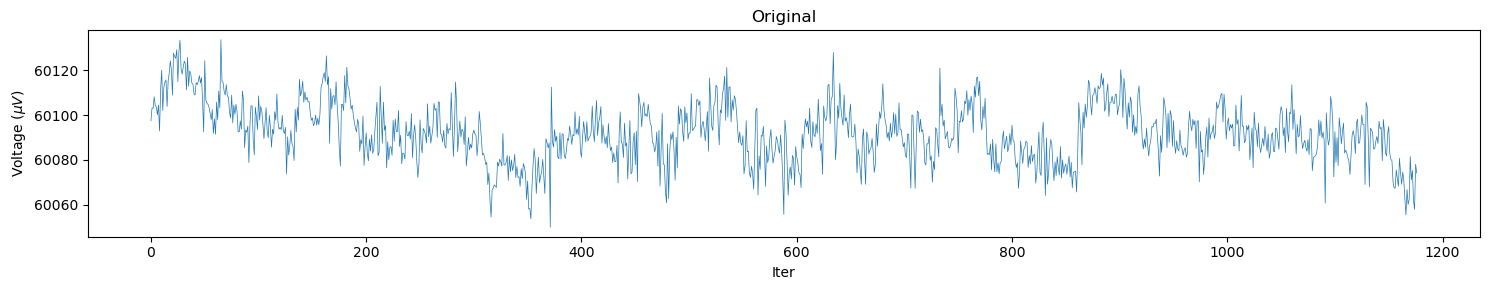

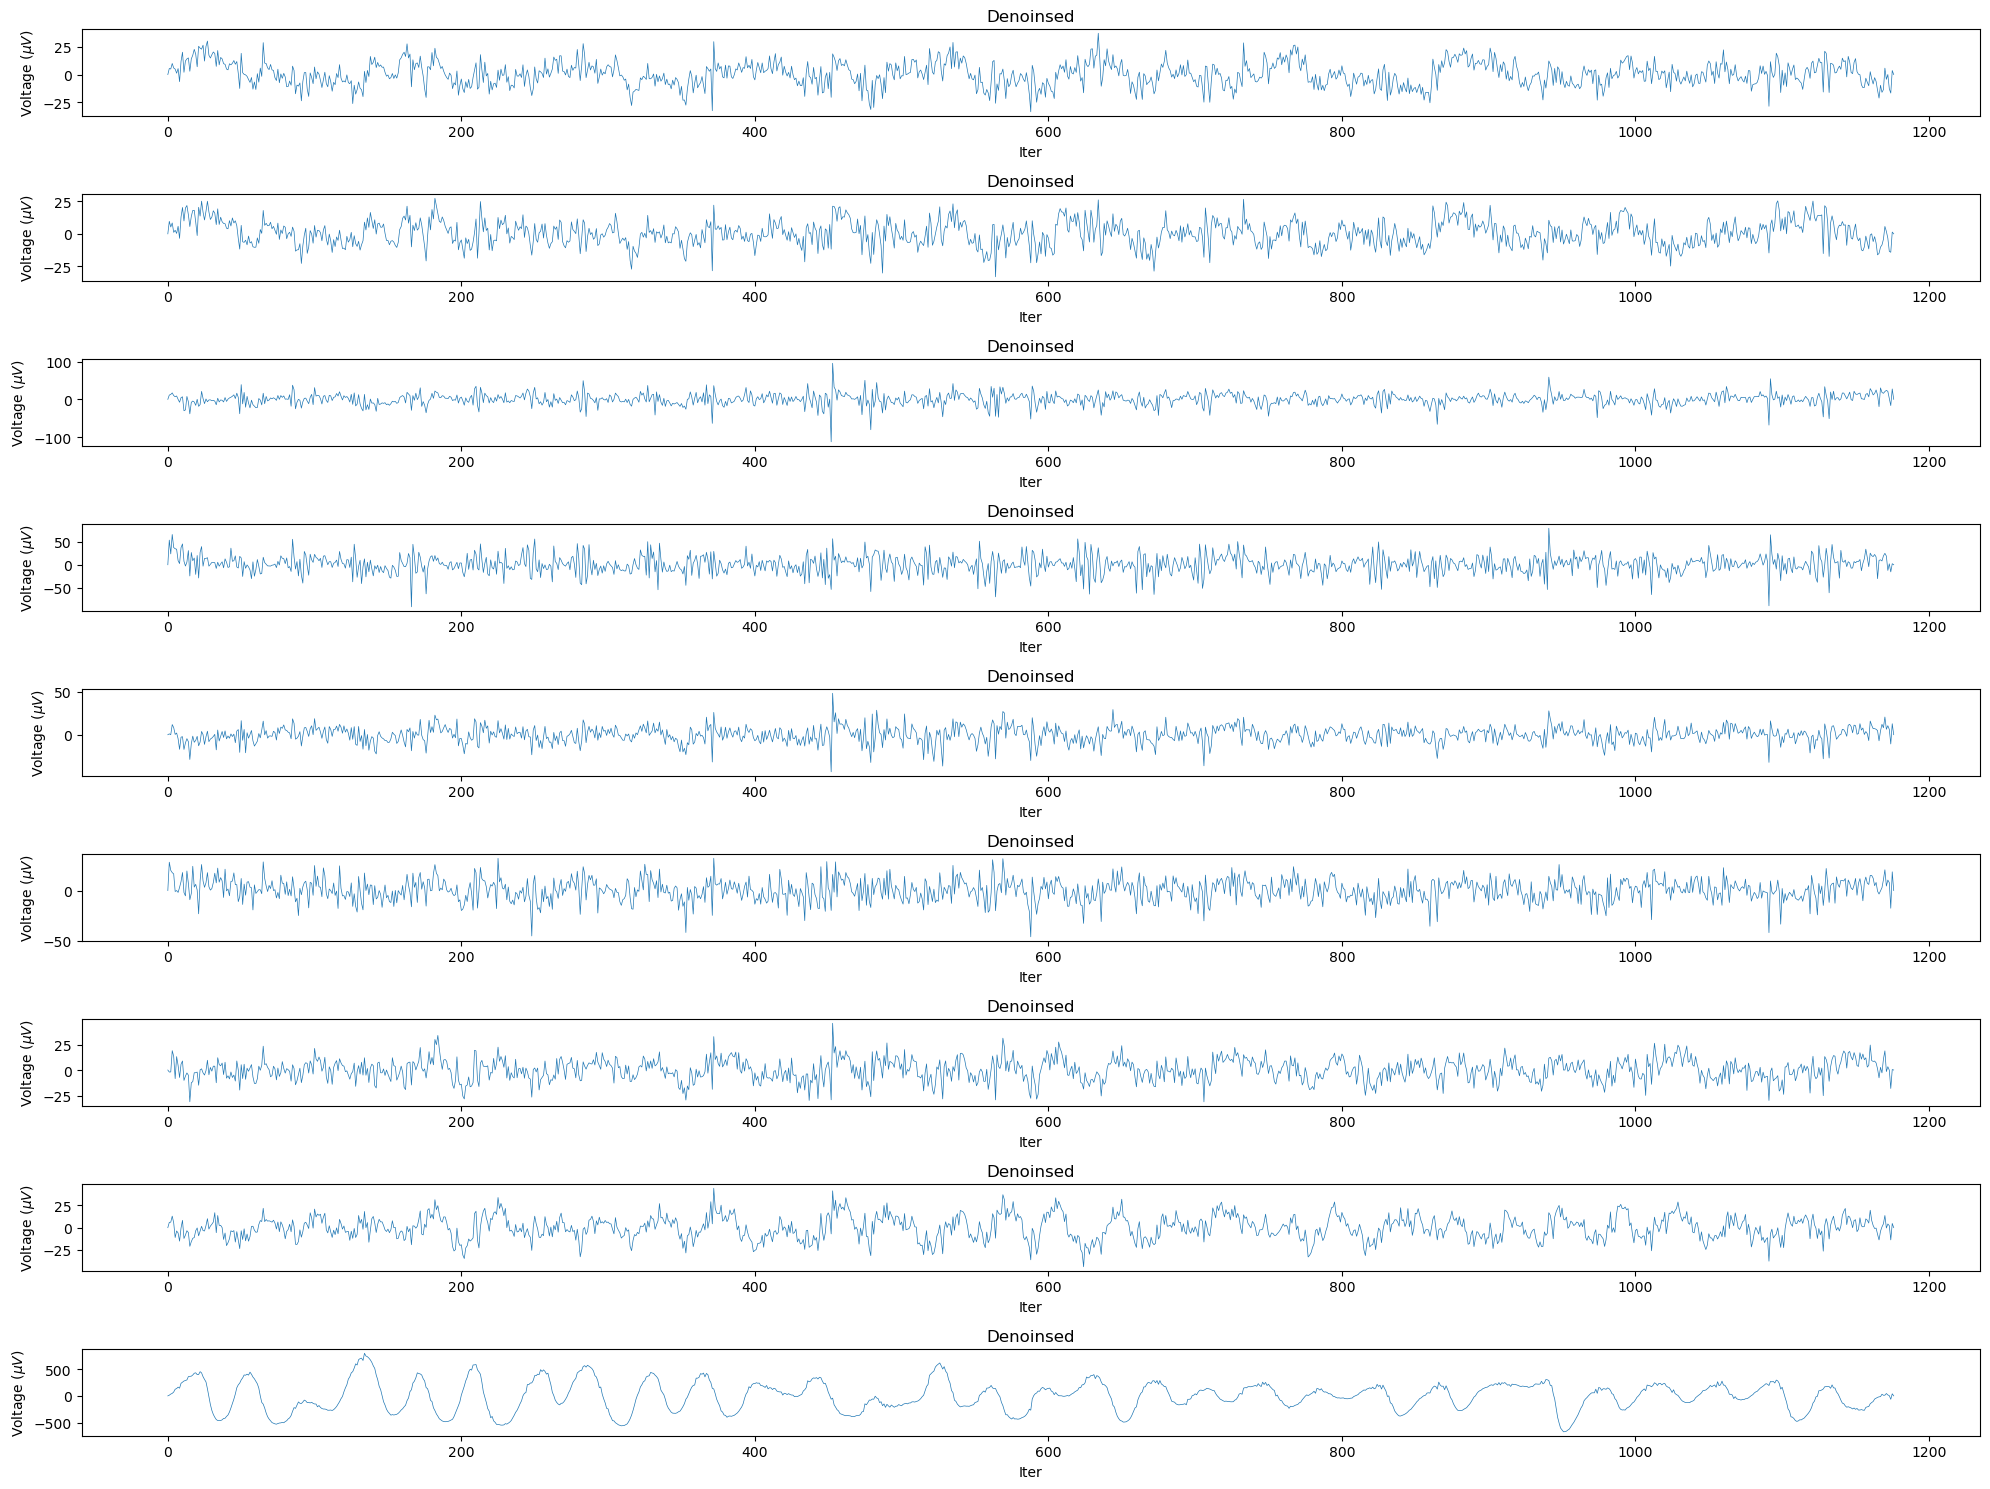

In [82]:
plot_eeg(df["EXG Channel 0"].to_numpy()[..., np.newaxis], figsize=(15, 3), title="Original")
plot_eeg(denoised_df.to_numpy(), title="Denoinsed")

In [83]:
#filtering experiment from below

In [84]:
denoised_df

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8
0,-2.898109e-12,1.816205e-11,6.239225e-12,-8.453174e-13,3.666173e-12,2.067781e-12,4.675225e-12,1.026740e-12,4.955716e-12
1,5.508207e+00,9.667687e+00,1.136405e+01,5.345998e+01,9.853559e-01,2.836967e+01,-1.977089e+00,5.962396e+00,1.312395e+01
2,5.073911e+00,5.300093e+00,1.301094e+01,2.343359e+01,7.318046e-02,2.020001e+01,-1.894789e+00,6.160355e+00,3.355549e+01
3,1.004972e+01,8.421926e+00,1.715991e+01,6.557476e+01,1.185596e+01,1.790875e+01,1.901881e+01,1.297502e+01,4.680568e+01
4,5.950622e+00,1.172478e+00,9.952692e+00,3.721300e+01,8.281158e+00,1.662263e+01,1.344111e+01,5.504396e+00,7.169148e+01
...,...,...,...,...,...,...,...,...,...
1172,9.576998e-02,-3.340971e+00,2.126396e+01,-1.233952e+01,1.053057e+01,1.044800e+01,3.262244e+00,4.146483e+00,1.728542e+01
1173,-1.284078e+01,-1.350828e+01,2.416272e+00,2.078181e+00,6.166490e+00,7.925479e+00,-1.156215e-01,2.227485e+00,4.249465e+00
1174,-1.675132e+01,-1.420181e+01,-1.661975e+01,-1.547330e+01,-1.085313e+01,-1.766773e+01,-1.809624e+01,-1.382163e+01,-6.348560e+01
1175,3.682486e+00,1.380199e+00,2.767245e+01,2.246980e+00,1.285531e+01,1.870029e+01,4.722472e-01,4.733199e+00,3.912281e+01


Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated
Not setting metadata
9 matching events found
No baseline correction applied
0 projection items activated


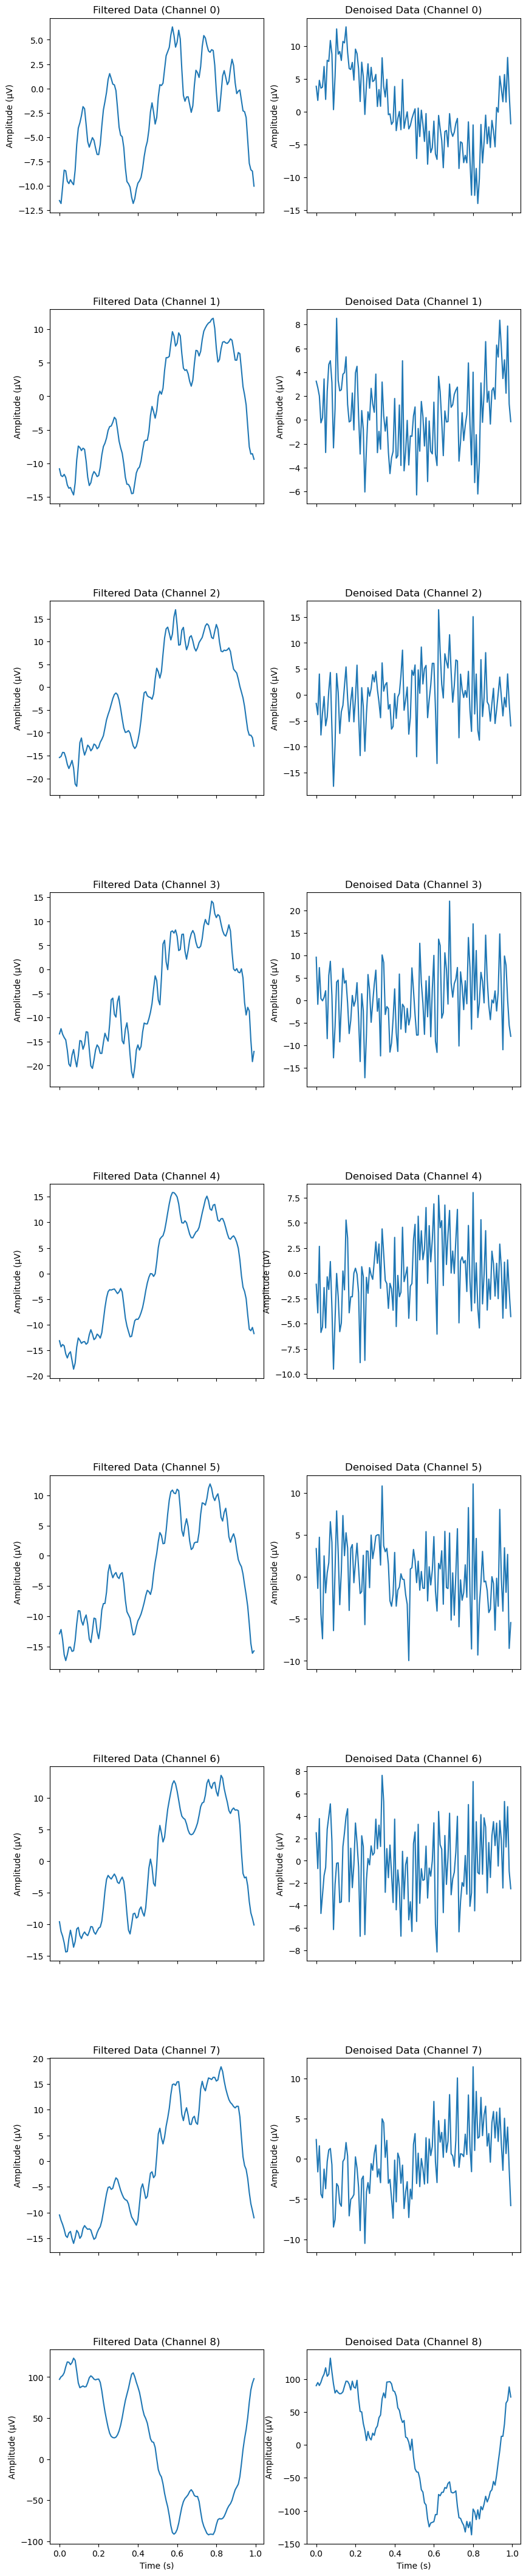

In [90]:
import numpy as np
import pandas as pd
from scipy import signal
from mne import create_info, EpochsArray
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore", category=FutureWarning)

# Sampling rate
sampling_rate = 125

# Bandpass filter
low_cut = 0.5  # Low cutoff frequency (Hz)
high_cut = 30  # High cutoff frequency (Hz)
nyquist = sampling_rate / 2
low = low_cut / nyquist
high = high_cut / nyquist
order = 4  # Filter order
normalized_cutoff = [low, high]
filter_coefficients = signal.butter(order, normalized_cutoff, btype='band', output='ba')

# Notch filter
notch_freq = 50  # Notch frequency (Hz) to remove power line noise
notch_quality_factor = 30  # Quality factor for the notch filter
notch_filter = signal.iirnotch(notch_freq, notch_quality_factor, sampling_rate)

# Apply filters and save filtered data to a new DataFrame
filtered_df = denoised_df.copy()
for col in filtered_df.columns:
    filtered_df[col] = signal.filtfilt(*filter_coefficients, filtered_df[col])
    filtered_df[col] = signal.filtfilt(*notch_filter, filtered_df[col])

# Re-reference to average
filtered_df = filtered_df.sub(filtered_df.mean(axis=1), axis=0)

# Baseline correction
baseline_start = 0  # Start time (in seconds) for baseline
baseline_end = 1  # End time (in seconds) for baseline
baseline_samples = slice(int(baseline_start * sampling_rate), int(baseline_end * sampling_rate))
baseline_mean = filtered_df.iloc[baseline_samples].mean()
filtered_df = filtered_df.sub(baseline_mean, axis=1)

# Imagined speech epoch extraction
epoch_duration = 1  # Duration of each epoch in seconds
epoch_start_time = 3  # Start time of epoch extraction in seconds
epoch_end_time = 10  # End time of epoch extraction in seconds
epoch_samples_per_epoch = int(epoch_duration * sampling_rate)

epochs_data_filtered = []
epochs_data_denoised = []

for i in range(len(filtered_df) // epoch_samples_per_epoch):
    epoch_data_filtered = filtered_df.iloc[i * epoch_samples_per_epoch : (i + 1) * epoch_samples_per_epoch].values.T
    epochs_data_filtered.append(epoch_data_filtered)

    # Assuming denoised_data is available with the same shape as filtered_data
    epoch_data_denoised = denoised_df.iloc[i * epoch_samples_per_epoch : (i + 1) * epoch_samples_per_epoch].values.T
    epochs_data_denoised.append(epoch_data_denoised)

# Create MNE info object
n_channels = len(filtered_df.columns)
ch_names = filtered_df.columns.tolist()
ch_types = ['eeg'] * n_channels
info = create_info(ch_names=ch_names, ch_types=ch_types, sfreq=sampling_rate)

# Create MNE EpochsArray for filtered data
epochs_filtered = EpochsArray(epochs_data_filtered, info)

# Create MNE EpochsArray for denoised data
epochs_denoised = EpochsArray(epochs_data_denoised, info)

# Plotting all channels
num_channels = len(epochs_filtered.ch_names)
fig, axs = plt.subplots(num_channels, 2, figsize=(10, 6*num_channels), sharex=True)

for i in range(num_channels):
    axs[i, 0].plot(epochs_filtered.times, epochs_filtered.get_data()[:, i, :].mean(axis=0))
    axs[i, 0].set_title(f'Filtered Data (Channel {i})')
    axs[i, 0].set_ylabel('Amplitude (μV)')

    axs[i, 1].plot(epochs_denoised.times, epochs_denoised.get_data()[:, i, :].mean(axis=0))
    axs[i, 1].set_title(f'Denoised Data (Channel {i})')
    axs[i, 1].set_ylabel('Amplitude (μV)')

# Set x-axis label only for the last subplot
axs[-1, 0].set_xlabel('Time (s)')
axs[-1, 1].set_xlabel('Time (s)')

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Display the plot
plt.show()


In [92]:
# Calculate mean of filtered EEG data for each channel
mean_data = filtered_df.mean()

# Create a new DataFrame to store the mean data
mean_df = pd.DataFrame(mean_data, columns=['Mean Amplitude (μV)'])

# Display the new DataFrame
print(mean_df)


               Mean Amplitude (μV)
EXG Channel 0            -2.929690
EXG Channel 1            -2.513046
EXG Channel 2            -1.427673
EXG Channel 3            -5.246568
EXG Channel 4            -0.837160
EXG Channel 5            -2.721210
EXG Channel 6            -0.711108
EXG Channel 7            -0.239026
EXG Channel 8            16.625481


In [ ]:
filtered_df.to_csv("filtered_data.csv", index=False)


In [93]:
denoised_df

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8
0,-2.898109e-12,1.816205e-11,6.239225e-12,-8.453174e-13,3.666173e-12,2.067781e-12,4.675225e-12,1.026740e-12,4.955716e-12
1,5.508207e+00,9.667687e+00,1.136405e+01,5.345998e+01,9.853559e-01,2.836967e+01,-1.977089e+00,5.962396e+00,1.312395e+01
2,5.073911e+00,5.300093e+00,1.301094e+01,2.343359e+01,7.318046e-02,2.020001e+01,-1.894789e+00,6.160355e+00,3.355549e+01
3,1.004972e+01,8.421926e+00,1.715991e+01,6.557476e+01,1.185596e+01,1.790875e+01,1.901881e+01,1.297502e+01,4.680568e+01
4,5.950622e+00,1.172478e+00,9.952692e+00,3.721300e+01,8.281158e+00,1.662263e+01,1.344111e+01,5.504396e+00,7.169148e+01
...,...,...,...,...,...,...,...,...,...
1172,9.576998e-02,-3.340971e+00,2.126396e+01,-1.233952e+01,1.053057e+01,1.044800e+01,3.262244e+00,4.146483e+00,1.728542e+01
1173,-1.284078e+01,-1.350828e+01,2.416272e+00,2.078181e+00,6.166490e+00,7.925479e+00,-1.156215e-01,2.227485e+00,4.249465e+00
1174,-1.675132e+01,-1.420181e+01,-1.661975e+01,-1.547330e+01,-1.085313e+01,-1.766773e+01,-1.809624e+01,-1.382163e+01,-6.348560e+01
1175,3.682486e+00,1.380199e+00,2.767245e+01,2.246980e+00,1.285531e+01,1.870029e+01,4.722472e-01,4.733199e+00,3.912281e+01


In [94]:
filtered_df

,EXG Channel 0,EXG Channel 1,EXG Channel 2,EXG Channel 3,EXG Channel 4,EXG Channel 5,EXG Channel 6,EXG Channel 7,EXG Channel 8
0,-7.875696,-8.510466,-15.039281,-14.311582,-11.601731,-11.390793,-9.891893,-8.908318,87.529759
1,-14.037049,-12.165801,-15.259844,8.109494,-21.787544,-2.222952,-21.924044,-13.963793,93.251534
2,-17.640592,-16.704833,-16.419459,17.140386,-24.551939,-1.950768,-22.320471,-15.884999,98.332676
3,-19.356408,-21.820549,-19.096057,15.273496,-22.566485,-10.138437,-17.711358,-18.360925,113.776725
4,-21.148609,-25.801143,-22.013552,10.858337,-22.638948,-20.440179,-19.016558,-25.008292,145.208944
...,...,...,...,...,...,...,...,...,...
1172,-18.176543,-17.810048,6.414541,-11.808084,0.717253,-2.142657,-6.638624,-4.681938,54.126099
1173,-15.541778,-15.407116,5.375815,-11.257676,5.158298,1.801273,-3.827867,0.154810,33.544240
1174,-12.607464,-11.899575,5.781654,-7.649470,6.001969,3.586868,-4.384244,0.375530,20.794732
1175,-9.451467,-8.658092,4.734351,-5.548088,3.416823,1.876382,-4.597787,-1.210972,19.438850
